# Two dimensional search, an optimization problem using EMNIST data

This is an exercise in trying to find the best match between two digital images. The objective function is the overlap in the images as measured by their correlation (the normalizeed covariance) of the two image vectors. Images that overlap precisely have high correlation. The match is modified by shifting one of the images in one of four directions.  The shift is given by a permutation matrix that moves pixels one unit at a time. (Of course if an image is shifted too far, the new pixels will all be blank and the correlation will plummet.)  

Pick two novel images of the same character.  Devise an incremental search routine (brute force "grid search" is workable) that searches over vertical and horizontal shifts to maximimize their correlation.

Do one of these improvements on your routine:

1). Come up with a shift matrix that moves the image just a fractional amount, to be able to search over continuous shifts.

2). Come up with other transform matrices for "affine" transforms, e.g. to rotate or scale an image.

3). Come up with a smarter search method that finds a direction (a "gradient" in the objective) likely to improve the correlation to speed up search.

4). Employ an existing search algorithm -- look at [scikit-optimize](https://scikit-optimize.github.io/stable/) for example.

5). Compare correlation with [mutual information](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mutual_info_score.html) as a measure of similarity.


JMA 7 Nov 2024

In [2]:
# An example of the typical imports for data science notebook
# not all will be used here

# Import python standard library
import re, os, sys, time
import math
import gzip
import struct
import pyarrow
from pathlib import Path
from dataclasses import dataclass

# A library specific to colab for mounting Google Drive folders
from google.colab import drive

# Load the standard data manipulation libraries
import numpy as np
import pandas as pd

# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
from bokeh.plotting import figure, show, row, save
from bokeh.models import ColumnDataSource, VBar, Span, Text, Label
from bokeh.io import output_notebook, output_file
output_notebook()


In [3]:
# Constants

DATA_DIR = Path('/content/drive/My Drive/ISE201_fall2024/_data/EMNIST')
A_FEW_CHARACTERS = 5

In [5]:
# Get access to the file system on Google Drive


# This function will bring up a dialog to authenticate using your
# Google identity
if not Path('/content/drive/').exists():
  drive.mount('/content/drive/')
os.chdir(DATA_DIR)
os.listdir('.')

Mounted at /content/drive/


['emnist-balanced-train-images-idx3-ubyte.gz',
 'emnist-balanced-test-images-idx3-ubyte.gz',
 'emnist-balanced-train-labels-idx1-ubyte.gz',
 'emnist-balanced-test-labels-idx1-ubyte',
 'emnist-balanced-mapping.txt',
 'emnist-byclass-train-images-idx3-ubyte.gz',
 'emnist-byclass-mapping.txt',
 'emnist-byclass-test-labels-idx1-ubyte.gz',
 'emnist-byclass-train-labels-idx1-ubyte.gz',
 'emnist-byclass-test-images-idx3-ubyte.gz',
 'emnist-bymerge-train-images-idx3-ubyte.gz',
 'emnist-bymerge-test-images-idx3-ubyte.gz',
 'emnist-bymerge-train-labels-idx1-ubyte.gz',
 'emnist-bymerge-test-labels-idx1-ubyte.gz',
 'emnist-bymerge-mapping.txt',
 'emnist-digits-train-images-idx3-ubyte.gz',
 'emnist-digits-test-labels-idx1-ubyte.gz',
 'emnist-digits-mapping.txt',
 'emnist-digits-test-images-idx3-ubyte.gz',
 'emnist-digits-train-labels-idx1-ubyte.gz',
 'emnist-letters-train-images-idx3-ubyte.gz',
 'emnist-letters-mapping.txt',
 'emnist-letters-test-images-idx3-ubyte.gz',
 'emnist-letters-test-labels-

In [ ]:

!gunzip emnist-balanced-test-labels-idx1-ubyte.gz

In [6]:
def loadimages_emnist(images_path):
    """Read MNIST from ubyte files.

    Parameters
    ----------
    images_path : str
        path to the test or train MNIST ubyte file
    Note: you must first unzip the files with !gunzip <filename>

    Returns
    --------
    images : [n_samples, n_pixels] numpy.array
        Pixel values of the images.

    """
    with open(images_path, "rb") as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(num, 784)
    return images

### The training data has a separate labels file ###########################
def loadlabels_emnist(labels_path):
    """Read MNIST from ubyte files.

    Parameters
    ----------
    labels_path : str
        path to the test or train MNIST class labels file

    Note: you must first unzip the files with !gunzip <filename>

    Returns
    --------
    labels : [n_samples] numpy array
        Target class labels

    """
    with open(labels_path, "rb") as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    return labels

# Recover the mapping from the labels to characters. The labels given in the original
# data are arbitray and don't follow conventional character encodings
def load_character_encodings(mapping_path):
  ''
  with open(mapping_path, 'r') as f:
    lines = f.readlines()
  char_encoding = [chr(int(k.split()[1])) for k in lines]
  return char_encoding

In [7]:
images = loadimages_emnist('emnist-balanced-test-images-idx3-ubyte')
labels = loadlabels_emnist('emnist-balanced-test-labels-idx1-ubyte')
char_encoding = load_character_encodings('emnist-balanced-mapping.txt')
images.shape, labels.shape, len(char_encoding)

((18800, 784), (18800,), 47)

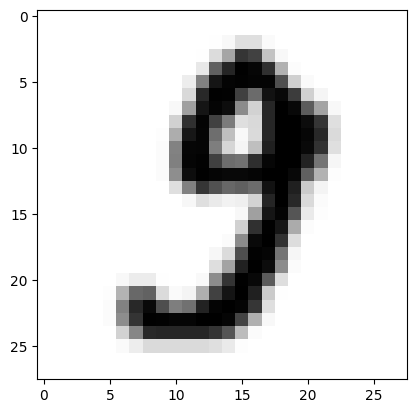

In [8]:
import matplotlib.pyplot as plt

plt.imshow(images[0].reshape(28, 28).T, cmap='binary')
plt.show()

In [9]:
# Plot the first few images using bokeh
renderings = []
for ch in range(A_FEW_CHARACTERS):
  im = figure(y_range=(28,0), x_range=(0,28), width=200, height=200, toolbar_location=None, x_axis_location=None, border_fill_color='darkgrey')
  im.image(image=[256-images[ch].reshape(28, 28).T], x=0, y=0, dw=28, dh=28, palette="Greys256")
  im.add_layout(Label(x=3, y=3, text = char_encoding[labels[ch]]))
  renderings.append(im)

show(row(*renderings))
# Save the graphic file
# Bokeh has a quirk where you can't run "show"  and  "save" at the same time.
#output_file('a_few_emnist.html')
#save(row(*renderings))

In [10]:
# Lets compare how similar images are by computing a correlation coef, on images treated
# as vectors of length 784.

# We see that the 3rd and 5th image ("9" and "q") have the higest correlation, for example.
few_images = images[:A_FEW_CHARACTERS,:]

corr_matrix = np.corrcoef(few_images)
corr_matrix

array([[1.        , 0.51137675, 0.4638618 , 0.10674136, 0.44077089],
       [0.51137675, 1.        , 0.34436674, 0.27567881, 0.25840758],
       [0.4638618 , 0.34436674, 1.        , 0.23917172, 0.58731337],
       [0.10674136, 0.27567881, 0.23917172, 1.        , 0.14435373],
       [0.44077089, 0.25840758, 0.58731337, 0.14435373, 1.        ]])

## Image shift operator

An permutation matrix with the upper off-diagonal set to one will shift every pixel to the left.  We show four repetitions of applying this matrix operator below.  The shift operator requires one extra step - to set the new pixels to "white" == 256.

Other shift operations in other directions can be created by a permutation operator on rotated versions of the image.

Since the permutation operator consists just of 1s and 0s it does not modify pixel values; it just moves them to different places.

In [26]:
# A permutation matrix that shifts each pixel one step left.
# The input is the image as a single vector of length 784, and the output is a vector of the
# same length.  The numpy matrix routines to create a matrix
# with ones just above the diagonal

right_shift = np.eye(784, k=1)
right_shift

renderings = []
shifted_image = 256-images[2].reshape(28, 28).T
shifted_image = shifted_image.flatten()
for ch in range(5):
  im = figure(y_range=(28,0), x_range=(0,28), width=200, height=200, toolbar_location=None, x_axis_location=None, border_fill_color='darkgrey')
  im.image(image=[shifted_image.reshape(28,28)], x=0, y=0, dw=28, dh=28, palette="Greys256")
  renderings.append(im)
  shifted_image = np.matmul(right_shift, shifted_image)
  # Set the last row to zeros
  si_transpose = shifted_image.T
  si_transpose[27*28+1: 28*28] = 256
  shifted_image = si_transpose.T

show(row(*renderings))

## Saving the 3 dataframes in 3 separate files.

This makes it convenient to reload datasets simply by using the pandas command `pd.read_parquet`.

One should use a filename that matches the source file, to preserve the identity of the data.


# Assume parquet needs a different file for each array object

In [ ]:
os.chdir('..')
if not os.path.exists('converted_files'):
  os.makedirs('converted_files', exist_ok=False)
os.chdir('converted_files')
pd.DataFrame(images).to_parquet('emnist_images.parquet')
pd.DataFrame(labels).to_parquet('emnist_labels.parquet')
pd.DataFrame(char_encoding).to_parquet('emnist_char_encoding.parquet')